In [8]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from math import pi
# qiskit
from qiskit import (
    IBMQ, execute, transpile,
    QuantumRegister, ClassicalRegister, QuantumCircuit,
)
# qurry
sys.path.insert(0, './')
from backend import backendWrapper
from mori import TagMap
print("Modules import completed...")
print("-"*30+"\n ### Init IBMQ and Set up provider")
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider(
    hub='ibm-q-hub-ntu', group='ntu-internal', project='default')
backend = backendWrapper(provider)
print("IBMQ loading completed...")

Modules import completed...
------------------------------
 ### Init IBMQ and Set up provider
IBMQ loading completed...


In [22]:
backend('auckland').properties().qubits[0]

[Nduv(datetime.datetime(2022, 7, 19, 12, 46, 35, tzinfo=tzlocal()), T1, us, 140.57646663031386),
 Nduv(datetime.datetime(2022, 7, 19, 12, 47, 44, tzinfo=tzlocal()), T2, us, 179.25205664916803),
 Nduv(datetime.datetime(2022, 7, 19, 20, 40, 29, tzinfo=tzlocal()), frequency, GHz, 4.93297746323154),
 Nduv(datetime.datetime(2022, 7, 19, 20, 40, 29, tzinfo=tzlocal()), anharmonicity, GHz, -0.3432263547868958),
 Nduv(datetime.datetime(2022, 7, 19, 12, 43, 24, tzinfo=tzlocal()), readout_error, , 0.006299999999999972),
 Nduv(datetime.datetime(2022, 7, 19, 12, 43, 24, tzinfo=tzlocal()), prob_meas0_prep1, , 0.0066),
 Nduv(datetime.datetime(2022, 7, 19, 12, 43, 24, tzinfo=tzlocal()), prob_meas1_prep0, , 0.006000000000000005),
 Nduv(datetime.datetime(2022, 7, 19, 12, 43, 24, tzinfo=tzlocal()), readout_length, ns, 757.3333333333333)]

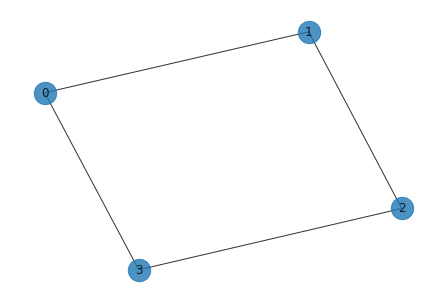

In [24]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

### The Mixing Unitary

In [25]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

┌───────────────┐
q_0: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_1: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_2: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_3: ┤ Rx(2*$\beta$) ├
     └───────────────┘

### The Problem Unitary

In [26]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

░                              ░      »
q_0: ──■──────────────────────■───░───■──────────────────────■───░──────»
     ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
q_1: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
     └───┘└────────────────┘└───┘ ░   │                      │   ░ ┌─┴─┐»
q_2: ─────────────────────────────░───┼──────────────────────┼───░─┤ X ├»
                                  ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ └───┘»
q_3: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░──────»
                                  ░ └───┘└────────────────┘└───┘ ░      »
«                             ░                              ░ 
«q_0: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_1: ────────────────────■───░──────────────────────────────░─
«     ┌────────────────┐┌─┴─┐ ░                              ░ 
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ 
«q_3: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─
«                             ░ └───┘└────────────────┘└───┘ ░

### The Initial State

In [28]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘

### The QAOA

In [29]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

┌─────────┐                             ░                              ░ »
q_0: ┤ U2(0,π) ├──■──────────────────────■───░───■──────────────────────■───░─»
     ├─────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░ »
q_1: ┤ U2(0,π) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░─»
     ├─────────┤└───┘└────────────────┘└───┘ ░   │                      │   ░ »
q_2: ┤ U2(0,π) ├─────────────────────────────░───┼──────────────────────┼───░─»
     ├─────────┤                             ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
q_3: ┤ U2(0,π) ├─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
     └─────────┘                             ░ └───┘└────────────────┘└───┘ ░ »
«                                  ░                              ░ »
«q_0: ─────────────────────────────░──────────────────────────────░─»
«                                  ░                              ░ »
«q_1: ──■──────────────────────■───░──────────────────────────────░─»
«     ┌─┴─┐┌────────────────┐┌─┴─┐ ░                              ░ »
«q_2: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─»
«     └───┘└────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
«q_3: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
«                                  ░ └───┘└────────────────┘└───┘ ░ »
«     ┌────────────────┐
«q_0: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_1: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_2: ┤ R(2*$\beta$,0) ├
«     ├────────────────┤
«q_3: ┤ R(2*$\beta$,0) ├
«     └────────────────┘

## The process

In [ ]:
def H_Ising(bitstring: str, Ising_coeff: np.ndarray):
    spins = []
    for bit in bitstring:
        if bit == '0':
            spins.append(-1)
        elif bit == '1':
            spins.append(1)
    H = 0
    for i in range(0, nqubits):
        H += Ising_coeff[i][i]*spins[i]
        for j in range(i+1, nqubits):
            H += Ising_coeff[i][j]*spins[i]*spins[j]
    return H


def compute_expectation(counts: dict, G: nx.Graph):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = H_Ising(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G: nx.Graph, theta: list[float]):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res